# Arrival Time Prediction - Synchronisation
This notebook is the third on the work on GP regression for arrival time prediction. The goal of this one is to estimate a function for each segment that synchonises the progress of all trajectories. This needs to be done so that predictions can be made based on a new trajectory and not a single data point.

The synchonisation function will be estimated using a GP, which we are all familiar now by now. First off, let's get some libraries into scope, set the seed and load the data that was pickled in the first notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import scipy.stats as stats 
import math
import tensorflow as tf
import plot
import GPy
import gp_gpy as gp
import synch

train = pd.read_pickle('train.pkl')
support = pd.read_pickle('support.pkl')
route_n = 3
traj_n = 7
sns.set(style="darkgrid")
np.random.seed(1)

## Hyperparameter Priors
The synchronisation function is a function $f : \mathcal{R}^2 \mapsto [0, 1]$ so we will use a bivariate GP model. Let's look at some priors for the hyperparameters kernel lengthscale, kernel variance and likelihood variance. We will not use this in the conventional sense of learning parameters using MAP (Maximum aposteriori), but for performing random restarts while learning using ML (Maximum likelihood). This needs to be done since GPs are quite prone to getting stuck in local minimas. Let's start with the kernel lengthscale parameter.

### Kernel Lenghtscale ($l$)
When the data was downsampled in the pre processing, it was done with $\delta = 3*10^{-2}$. Based on this we have implicitly said that points that have a distance of delta are close by, so the lengthscale prior should reflect that.

Since GPFlow is quite a minimalistic library (that is: a bit buggy, and poorly documented), there is no way of plotting kernel functions, and the function to compute covariance matrices at all, `k.compute_K`, seem to be busted beyond belief. Plotting will have to be done by implementing the function by oneself and using it for plotting. Thus you find an implementation of the RBF kernel function below. 

The goal is to find an $l$ of the RBF that makes it wide enough to consider points within delta distance as close. Trying some different values shows that $l = 0.25$ gives something that would consider the closest $10$ points close and then decay noticeably.

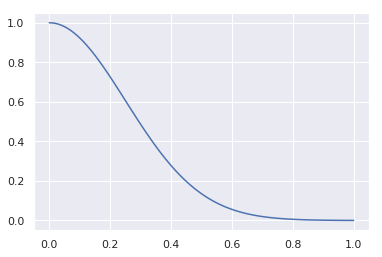

In [2]:
def rbf(X, x, var, l):
      return var*np.exp(-(abs(X-x)*abs(X-x))/(2*math.pow(l, 2)))

xmin = 0
xmax = 1
xx = np.linspace(xmin, xmax, 100)[:,None]
sns.lineplot(x=xx[:,0], y = rbf(xx, 0, 1, 0.25)[:,0])

Having concluded a value of $l$ that makes sense, we now put a distribution over it with mean around the chosen value and a variance representing our certainty. I am not too certain in my belief, and believe that $l$ could take on values quite a bit bigger than the mean value. Since the length scale is strictly positive I've chosen a gamma distribution, which it can be seen in the plot below. This is our length scale prior!

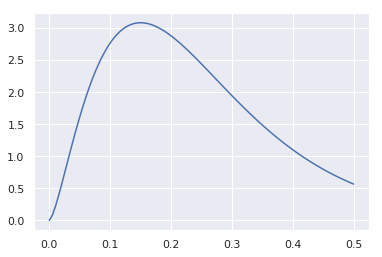

In [3]:
xmin = 0
xmax = 0.5
l_alpha = 2.5
l_theta = 0.1
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=l_alpha, scale=l_theta)
sns.lineplot(x = xx[:,0], y = y[:,0])

### Kernel Variance ($\sigma_f$)
The kernel variance determines the average distance that the function output has from the function mean. Since the output of the function is on $[0, 1]$, the output should not need to vary more than this. To prevent overfitting a $\sigma_f = 0.6$ seems right, but let's go with quite high uncertainty on this one. Since it is also a strictly positive quantity a gamma distribution is used here as well, like with the lengthscale.

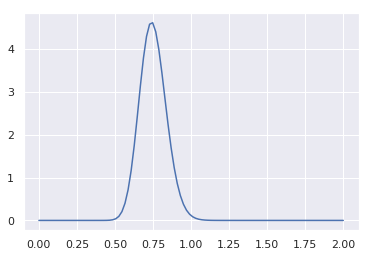

In [4]:
xmin = 0
xmax = 2
sigmaf_alpha = 75
sigmaf_theta = 0.01
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=sigmaf_alpha, scale=sigmaf_theta)
sns.lineplot(x = xx[:,0], y = y[:,0])

### Likelihood Variance ($\sigma$)
We also need to chose a prior for the likelihood variance $\sigma$, which representas the measurement noise. This model will assume a static variance, even though we know that it depends on where in the city you are. In mode dense areas the GPS accuracy suffers a bit while it works well in more rural areas. A seperate model for the GPS variance estimation should be used if this was done properly.

In the provided thesis the average GPS variance of a smartphone is claimed to be $\sigma = 10^-5$ so we'll go with that, but like with $\sigma_f$ we will be quite uncertain.

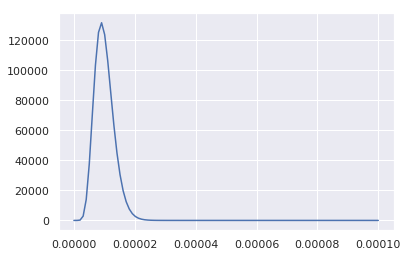

In [ ]:
xmin = 0
xmax = 0.0001
sigma_alpha = 10
sigma_theta = 0.000001
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=sigma_alpha, scale=sigma_theta)
sns.lineplot(x = xx[:,0], y = y[:,0])

In [ ]:
d_lat = train.lat.max() - train.lat.min()
d_lon = train.lon.max() - train.lon.min()
print(d_lat, d_lon)


0.04740428924559836 0.009750366210909078


# Training
Alrighty, time to train a GP. The idea here is to train on a single trajectory that embodies what we want from the synchronisation. This works because the model is used to interpolation and has consequently no need to generalise. We use both the training and support data for this model, for reasons mentioned in notebook 1.

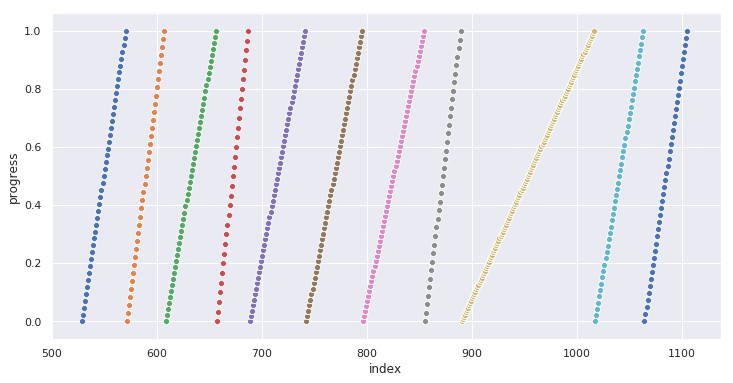

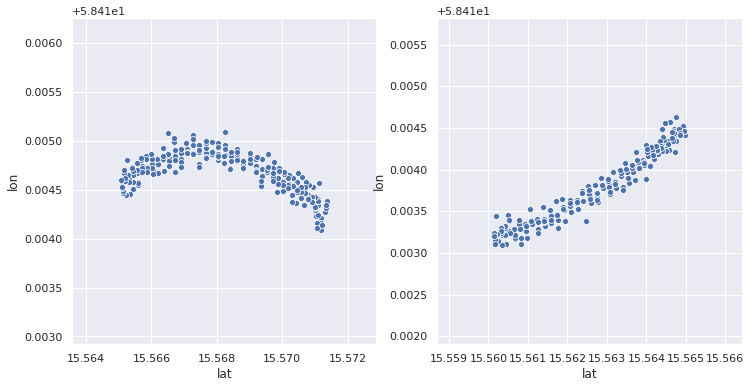

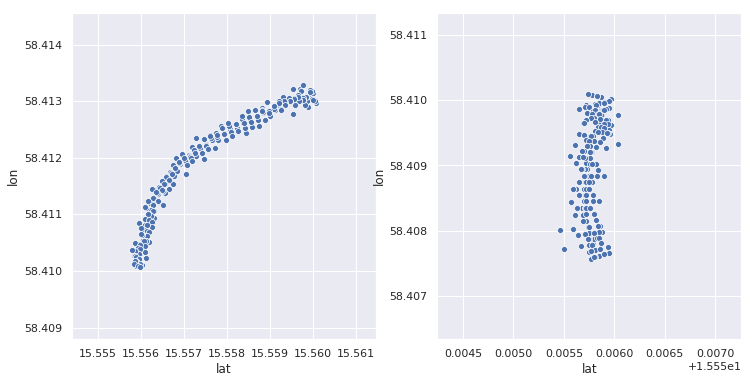

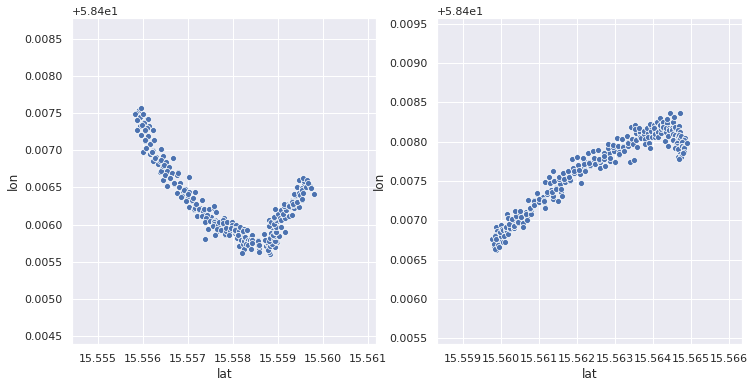

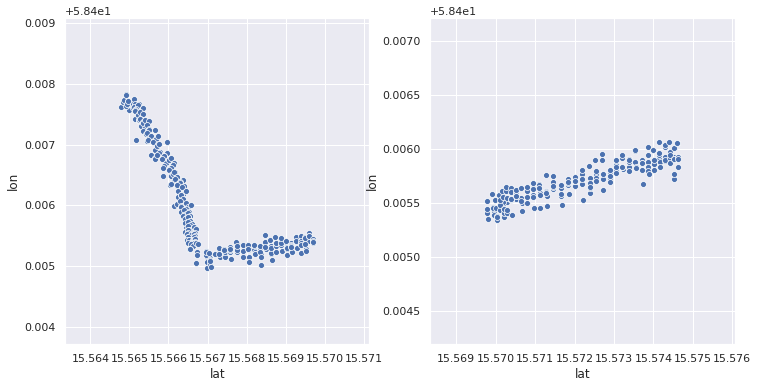

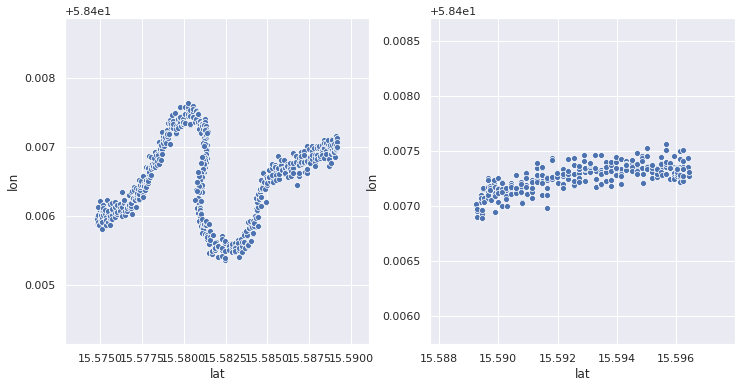

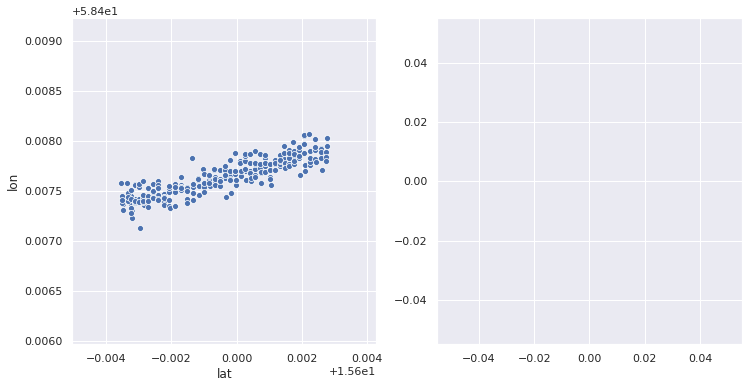

In [ ]:
n_trajs = train.traj.unique()
traj_n = n_trajs[1]
traj = train[train.traj == traj_n]
traj_support = support[support.traj == traj_n]
train_traj = traj.append(traj_support)
plot.traj_progress(train_traj)
plot.traj_segment_grid(train_traj, 'lat', 'lon')

Having found a seg_n that seems typical we can now fit GPs for each of its segments.

In [ ]:
def train_gp(data, route_n, traj_n, seg_n):
    seg = data[data.seg == seg_n]
    #print(seg)
    d_lat = train.lat.max() - train.lat.min()
    d_lon = train.lon.max() - train.lon.min()
    model = gp.build_synch(seg, ['lat', 'lon'], ['progress'], seg_n)
    model.model.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(0.5, 0.1))
    model.model.kern.variance.set_prior(GPy.priors.Gamma.from_EV(0.5, 0.01))
    model.model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(0.1, 0.1))
    gp.train(model, 5)
    return model

np.random.seed(2)
n_segs = traj.seg.unique()
gps = [train_gp(train_traj, route_n, traj_n, seg_n) for seg_n in n_segs]

#train_gp(train_traj, route_n, 1, 4)


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -668.5601825983059
Optimization restart 2/5, f = -668.5601826265076
Optimization restart 3/5, f = -668.5601826242146


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -668.5601826274711
Optimization restart 5/5, f = -668.5601826274792
Optimization restart 1/5, f = -714.1196472562652
Optimization restart 2/5, f = -714.1196472556162
Optimization restart 3/5, f = -714.1196472559883


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -714.1196472560628
Optimization restart 5/5, f = -714.1196472538747


In [ ]:
def plot_gps(gps):
    for model in gps:
        gp.plot(model)

plot_gps(gps)

Using the support data together with stop compression has given amazing results and the synchronisation is a success. Below is a plot of the synchronisation of some unseen new trajectories to test its robustness.

In [ ]:
def synch_data(synch_gp, data):
    latlon  = ['lat', 'lon']
    X = data[latlon].values
    tau, _var = gp.predict(synch_gp, X)
    synched_data = data.copy()
    synched_data['tau'] = tau
    synched_data.drop(xy, axis=1)
    return synched_data

test = pd.read_pickle('test.pkl')
test_traj_n = test.traj.unique()[0]
test_traj = [test.traj == test_traj_n]

_fig, ax = plt.subplots(nrows=len(n_segs), ncols=1, figsize=(6, int(6*len(n_segs))))
for seg_n in n_segs:
    seg = test[test.seg == seg_n]
    X = seg[['lat', 'lon']].values
    tau, _var = gp.predict(gps[int(seg_n)-1], X)
    df = pd.DataFrame({'pred': tau.T[0], 'X': seg.progress})
    sns.scatterplot(data=df, x='X', y='pred', ax=ax[int(seg_n)-1])
        
#plot.traj_segment_grid(test, 'progress', 'tau')
    


We see that the synchronisation is quite robust, and so we save the trajectories.

In [ ]:
n_segs = traj.seg.unique()
for synch_gp in gps:
     gp.save(synch_gp)

A final test of the load functions and plotting of (training) predictions

In [ ]:
from sklearn.preprocessing import scale

_fig, ax = plt.subplots(nrows=len(n_segs), ncols=1, figsize=(6, int(6*len(n_segs))))
for seg_n in n_segs:
    seg = traj[traj.seg == seg_n]
    sgp = gp.load_synch(seg_n)
    X = scale(seg[['lat', 'lon']].values)
    mean, _var = gp.predict(sgp, X)
    df = pd.DataFrame({'pred': mean.T[0], 'X': range(X.shape[0])})
    sns.scatterplot(data=df, x='X', y='pred', ax=ax[int(seg_n)-1])